# Airplane Wildlife Dataset EDA
## By James Zhang and Vijaykaarti Sundarapandiyan

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels as sm
import matplotlib.pyplot as plt
import sklearn

## Data Preprocessing

Before any machine learning models or statistical tests, let us first get a feel for our dataset by conducting some basic data preprocessing, which includes identifying useful characteristics and converting features to appropriate types.

In [2]:
df = pd.read_csv("data.csv")
# Immediately drop duplicates, if there are any.
df = df.drop_duplicates()
display(df.head())
f'There are {df.shape[0]} rows and {df.shape[1]} columns'

/var/folders/c_/099s8fjn6s75fb1c5qq8m5p40000gn/T/ipykernel_12721/242121122.py:1: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,6/22/1996,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,6/26/1996,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,7/1/1996,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,7/1/1996,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,7/1/1996,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False


'There are 288810 rows and 100 columns'

Our dataset has $288, 810$ rows/entries and $100$ columns/features. $100$ features gives us lots of options to choose from when it comes to feature selection, machine learning models, regressions, and hypothesis tests. To get more information about each feature, we can use `df.info()` to find out some basic information like the Non-Null Count and datatype.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288810 entries, 0 to 288809
Data columns (total 100 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   INDEX_NR               288810 non-null  int64  
 1   INCIDENT_DATE          288810 non-null  object 
 2   INCIDENT_MONTH         288810 non-null  int64  
 3   INCIDENT_YEAR          288810 non-null  int64  
 4   TIME                   163633 non-null  object 
 5   TIME_OF_DAY            166394 non-null  object 
 6   AIRPORT_ID             288804 non-null  object 
 7   AIRPORT                288810 non-null  object 
 8   LATITUDE               253309 non-null  float64
 9   LONGITUDE              253308 non-null  float64
 10  RUNWAY                 218852 non-null  object 
 11  STATE                  253309 non-null  object 
 12  FAAREGION              253309 non-null  object 
 13  LOCATION               33939 non-null   object 
 14  ENROUTE_STATE          5037 non-nul

On a high level, our features can be categorized in the following manner:
- Time `(INCIDENT_DATE, TIME, TIME_OF_DAY)`
- Metadata `(SOURCE, INDEX_NR, AIRPORT)`
- Physics-related `(AC_MASS, HEIGHT, SPEED, DISTANCE)`
- Species-related `(SPECIES, SPECIES_ID, REMAINS_COLLECTED, NR_INJURIES)`
- Money-related `(COST_REPAIRS, COST_REPAIRS_INFL_ADJ, COST_OTHER)`
- Categorical `(WARNED, SKY, AIRCRAFT)`
- Boolean `(DAM_RAD, DAM_WINDSHIELD, STR_ENG1)`

Once more, there is more than sufficent data collected in this dataset. Furthermore, the owners of the dataset have done a pretty good job of converting columns to the appropriate datatypes, ie. to float and string when needed. The only additional needed preprocessing is with respect to the time-related columns. Conversion for the `INCIDENT_DATE` column to `pd.datetime` is trivial. The `TIME` column required a little bit more effort, however. There were some errors in the data such as NaN values and minute recordings between greater than $60$, which doesn't make sense. See our implementation below. 

In [7]:
def time_helper(x):
    # If nan, then just return nan.
    if not isinstance(x, float):
        return np.NaN
    # We want at least hour and minute precision.
    elements = str(x).split(':')
    if len(elements) < 2:
        return np.NaN
    # Ensure validity of hours and minutes before returning.
    h, m = int(elements[0]), int(elements[1])
    return x if h in range(0, 13) and m in range(0, 61) else np.NaN

# Convert these columns datetime.
df["INCIDENT_DATE"] = pd.to_datetime(df["INCIDENT_DATE"])
df["TIME"] = df["TIME"].apply(time_helper)
df["TIME"] = pd.to_datetime(df["TIME"])

## Basic Data Exploration and Summary Statistics

We can also print out some summary statistics for each of our numerical columns using the `df.describe()` method. Note that some of these entries are meaningless; for example, the standard deviation of the Latitude column holds no weight. On the other hand, some entries such as the mean speed of the airplane can be useful for later analysis, but this representation is overall pleasant and informational. 

In [5]:
df.describe()

,INDEX_NR,INCIDENT_MONTH,INCIDENT_YEAR,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,ENG_1_POS,ENG_2_POS,ENG_3_POS,ENG_4_POS,HEIGHT,SPEED,DISTANCE,AOS,BIRD_BAND_NUMBER,NR_INJURIES,NR_FATALITIES
count,2.888100e+05,288810.000000,288810.000000,2.533090e+05,253308.000000,192151.000000,186756.000000,206490.000000,206259.000000,205481.000000,191612.000000,13080.000000,3290.000000,148807.000000,94237.000000,188234.000000,14196.000000,3.900000e+02,276.000000,24.000000
mean,8.736693e+05,7.175974,2011.697798,2.012754e+02,-90.880247,19.755812,8.522377,3.538312,2.013929,2.814956,2.667536,2.900306,2.043161,865.960358,142.585057,0.814466,91.454416,8.811022e+07,1.293478,2.041667
std,2.526448e+05,2.765082,8.432311,8.177522e+04,327.243918,10.724278,12.866405,0.867312,0.420133,2.113806,1.981032,1.950649,1.435114,1843.098801,46.650050,3.547950,661.074472,9.110186e+07,0.756134,1.654484
min,6.082420e+05,1.000000,1990.000000,-3.767333e+01,-177.381000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,6.893202e+05,5.000000,2006.000000,3.298764e+01,-98.469780,10.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,120.000000,0.000000,1.000000,0.000000e+00,1.000000,1.000000
50%,7.646935e+05,7.000000,2014.000000,3.880581e+01,-87.904460,22.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,50.000000,140.000000,0.000000,3.000000,7.897730e+07,1.000000,1.500000
75%,1.064714e+06,9.000000,2019.000000,4.085010e+01,-80.417940,31.000000,10.000000,4.000000,2.000000,5.000000,5.000000,5.000000,4.000000,900.000000,160.000000,0.000000,24.000000,1.893343e+08,1.000000,2.000000
max,1.472259e+06,12.000000,2023.000000,4.115443e+07,164140.000000,92.000000,2301.000000,5.000000,4.000000,7.000000,7.000000,6.000000,5.000000,31300.000000,1250.000000,99.000000,62848.000000,2.821218e+08,7.000000,8.000000


We can also display and print out the correlation matrix to get a sense of the relationships between columns in our dataset.

/var/folders/c_/099s8fjn6s75fb1c5qq8m5p40000gn/T/ipykernel_12721/2606678425.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number)


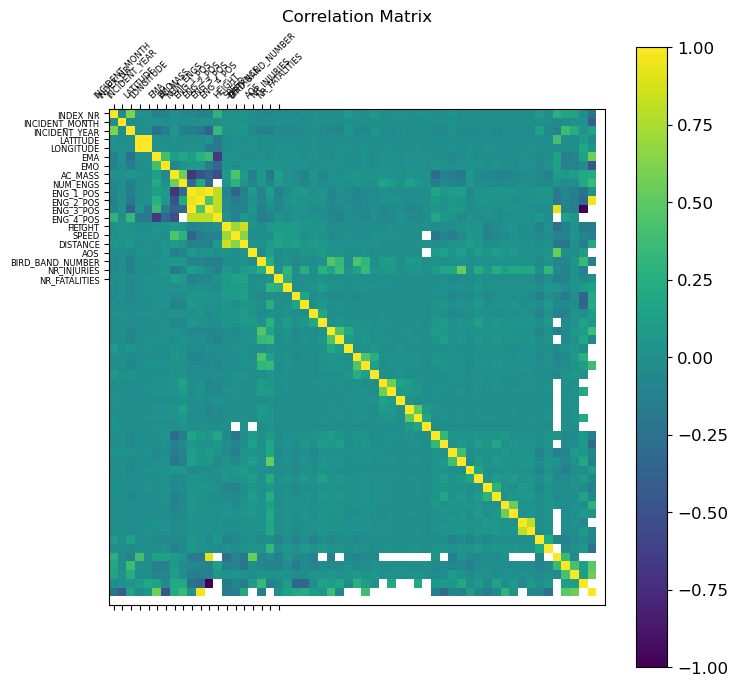

In [15]:
f = plt.figure(figsize=(8, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=6, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=6)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=12);

plt.show()

In [13]:
df.corr()

/var/folders/c_/099s8fjn6s75fb1c5qq8m5p40000gn/T/ipykernel_12721/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,INDEX_NR,INCIDENT_MONTH,INCIDENT_YEAR,LATITUDE,LONGITUDE,EMA,EMO,AC_MASS,NUM_ENGS,ENG_1_POS,...,STR_LGHTS,DAM_LGHTS,STR_OTHER,DAM_OTHER,BIRD_BAND_NUMBER,REMAINS_COLLECTED,REMAINS_SENT,NR_INJURIES,NR_FATALITIES,TRANSFER
INDEX_NR,1.000000,-0.017196,0.614040,0.004333,0.005524,-0.124351,-0.097162,0.022446,-0.067104,-0.076932,...,-0.005214,-0.007927,0.084779,-0.005025,0.263531,0.181929,0.165749,-0.001681,-0.266770,NaN
INCIDENT_MONTH,-0.017196,1.000000,-0.030156,-0.002243,0.005182,0.010470,0.000183,0.004241,0.001803,0.003881,...,-0.002906,-0.003952,-0.010625,-0.002859,-0.053243,-0.005568,0.025033,0.011434,-0.395503,NaN
INCIDENT_YEAR,0.614040,-0.030156,1.000000,0.002702,0.002914,-0.260499,-0.160136,0.040291,-0.139759,-0.137522,...,-0.020877,-0.026900,0.141357,-0.048481,-0.112464,0.379515,0.245456,0.039581,0.156706,NaN
LATITUDE,0.004333,-0.002243,0.002702,1.000000,0.997101,0.000573,-0.000337,0.001249,-0.000127,-0.002121,...,-0.000133,-0.000113,-0.000805,-0.000173,0.399586,-0.002076,-0.000766,0.098190,-0.046760,NaN
LONGITUDE,0.005524,0.005182,0.002914,0.997101,1.000000,0.010744,0.005432,-0.002039,0.005589,0.000088,...,-0.000130,0.000002,-0.001701,-0.000142,-0.009593,-0.003695,-0.001666,0.217687,0.055328,NaN
EMA,-0.124351,0.010470,-0.260499,0.000573,0.010744,1.000000,0.391340,0.126054,0.204614,0.115243,...,0.001078,0.007082,-0.048208,-0.007208,0.150081,-0.130276,-0.099353,0.152825,0.575296,NaN
EMO,-0.097162,0.000183,-0.160136,-0.000337,0.005432,0.391340,1.000000,-0.060022,0.020434,0.079959,...,0.008949,0.011041,-0.051020,0.015033,0.144461,-0.114708,-0.089319,-0.031445,-0.481945,NaN
AC_MASS,0.022446,0.004241,0.040291,0.001249,-0.002039,0.126054,-0.060022,1.000000,0.556690,-0.693702,...,-0.029257,-0.029032,-0.039460,-0.094789,0.108887,0.078740,0.121793,0.225294,0.233767,NaN
NUM_ENGS,-0.067104,0.001803,-0.139759,-0.000127,0.005589,0.204614,0.020434,0.556690,1.000000,-0.301937,...,-0.014636,-0.011739,-0.051201,-0.050889,0.032385,-0.035018,-0.009929,0.213599,0.349205,NaN
ENG_1_POS,-0.076932,0.003881,-0.137522,-0.002121,0.000088,0.115243,0.079959,-0.693702,-0.301937,1.000000,...,0.030508,0.029775,0.048594,0.060182,-0.170083,-0.075260,-0.141271,-0.245036,0.016922,NaN
